# DATA 620 - Project 4 (Week 12)



In [129]:
import nltk
import random
import itertools
import pandas
import numpy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# import the movie review corpus
from nltk.corpus import movie_reviews

# graphics
import matplotlib.pyplot as plt
import seaborn

# set display digits
display_digits=4
# inline matplotlib
%matplotlib inline
# define random seed
random_seed=1534678

We have positive and negative reviews:

In [130]:
movie_reviews.categories()

[u'neg', u'pos']

Each movie review is stored in a single text file:

In [131]:
movie_reviews.fileids('pos')[1:10]

[u'pos/cv001_18431.txt',
 u'pos/cv002_15918.txt',
 u'pos/cv003_11664.txt',
 u'pos/cv004_11636.txt',
 u'pos/cv005_29443.txt',
 u'pos/cv006_15448.txt',
 u'pos/cv007_4968.txt',
 u'pos/cv008_29435.txt',
 u'pos/cv009_29592.txt']

We iterate over each text file and read it into a list of lists, organized by category:

In [132]:
# organize movie reviews by category
documents = [(list(movie_reviews.words(fileid)), category)
    for category in movie_reviews.categories()
    for fileid in movie_reviews.fileids(category)]
# set random seed
random.seed(random_seed)
# shuffle reviews 
random.shuffle(documents)
# convert words to lowercase
all_words = nltk.FreqDist(w.lower() for w in movie_reviews.words())
# extract 2000 most frequent words
word_features = all_words.keys()[:2000]

In [133]:
len(word_features)

2000

In [134]:
word_features[1:10]

[u'askew',
 u'woods',
 u'spiders',
 u'bazooms',
 u'hanging',
 u'francesca',
 u'comically',
 u'localized',
 u'disobeying']

Define function to create feature set:

In [135]:
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)

    return features

Split the data into training and test sets:

In [136]:
# split data into training and test sets
train_documents, test_documents = documents[100:], documents[:100]

In [137]:
# display size of training and test sets
print("Training Set = {}".format(len(train_documents)))
print("Test Set = {}".format(len(test_documents)))

Training Set = 1900
Test Set = 100


We define a few functions to train and evaluate the Naive Bayes classifier on the training and testing data sets:

In [138]:
# define function to normalize confusion matrix
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

# define function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          yLabelFlag = True):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    # add y-label if flag is True
    if yLabelFlag == True:
        plt.ylabel('True Label')
    
    plt.xlabel('Predicted Label')

    return

# plot confusion matrix for both train and test data sets
def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(8,8))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False,
        yLabelFlag=True)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True,
        yLabelFlag=False)
    
    return

# define function to evaluate Naive Bayes classifier
def evaluate_naive_bayes_classifier(train_documents,test_documents):
    # create feature set (train)
    train_feature_set = [(document_features(d), c) for (d,c) in train_documents]
    # create feature set (dev test)
    test_feature_set = [(document_features(d), c) for (d,c) in test_documents]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_feature_set) 
    
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_feature_set)
    # compute accuracy (development test set)
    test_accuracy=nltk.classify.accuracy(classifier, test_feature_set)
    
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(document_features(d)) for (d,c) in train_documents]
    # extract actual classes (gold)
    train_set_gold = [c  for (d,c) in train_documents]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (test)
    test_set_predictions = [classifier.classify(document_features(d)) for (d,c) in test_documents]
    # extract actual classes (gold)
    test_set_gold = [c  for (d,c) in test_documents]
    # create confusion matrix
    test_cm=confusion_matrix(test_set_gold, test_set_predictions)
    # get unique classes (test)
    test_label_names =  list(set(test_set_gold) | set(test_set_predictions))
    # create table with precision, recall, f1-score, and support
    test_report=classification_report(test_set_gold, test_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,test_accuracy,test_cm,test_label_names,test_report,classifier

## Model Training & Evaluation

Train and evaluate the Naive Bayes classifier on the training and testing documents (i.e., movie reviews):

In [139]:
# train and evaluate Naive Bayes classifier
train_accuracy_nb1,train_cm_nb1,train_label_names_nb1,train_report_nb1, \
    test_accuracy_nb1, test_cm_nb1,test_label_names_nb1, \
    test_report_nb1, classifier_nb1=evaluate_naive_bayes_classifier( \
    train_documents,test_documents)

Display the model accuracy and plot the confusion matrix for both the training and testing data sets:

Accuracy (Train): 0.842631578947
Accuracy (Test): 0.75


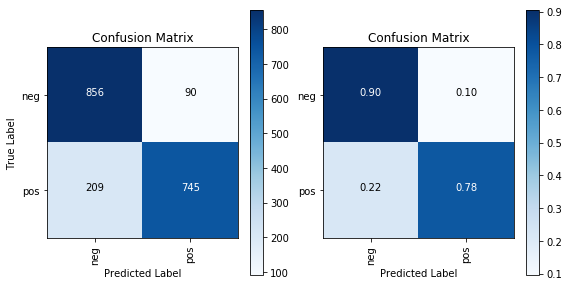

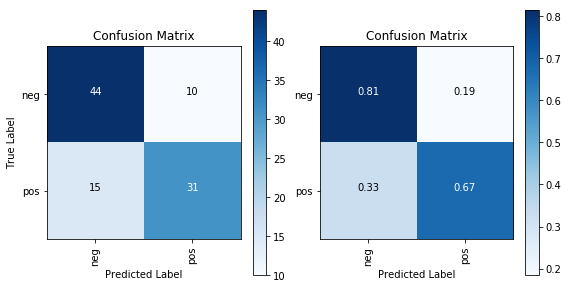

In [140]:
# display model accuracy (train and test)
print('Accuracy (Train): '+str(train_accuracy_nb1))
print('Accuracy (Test): '+str(test_accuracy_nb1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb1,['neg','pos'])
# plot confusion matrix (test)
plot_both_confusion_matrix(test_cm_nb1,['neg','pos'])

Display the performance metrics for the training and testing data sets:

In [141]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb1)
# display performance report (test)
print('Model Performance Metrics (Test):')
print(test_report_nb1)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        neg     0.8038    0.9049    0.8513       946
        pos     0.8922    0.7809    0.8329       954

avg / total     0.8482    0.8426    0.8421      1900

Model Performance Metrics (Test):
             precision    recall  f1-score   support

        neg     0.7458    0.8148    0.7788        54
        pos     0.7561    0.6739    0.7126        46

avg / total     0.7505    0.7500    0.7483       100



Define function to return data frame of likelihoods associated with $N$ most important features:

In [142]:
# most informative feature function (based on NLTK package function
# show_most_informative_features)
def most_informative_features_in_df(classifier, n=30):
    # probability distribution for feature values given labels
    cpdist = classifier._feature_probdist       
    feature_prob_list = []
    feature_prob_list0 = []
    feature_prob_list1 = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
            key=labelprob)

        if len(labels) == 1:
            continue
        l0 = labels[0]
        l1 = labels[-1]
                
        ratioValue=cpdist[l1, fname].prob(fval) / cpdist[l0, fname].prob(fval)
        
        #feature_list.append([fname, labels[-1]])
        feature_prob_list.append([fname, labels[-1],ratioValue])
        
    # define column names
    columnNames=['featureName','featureValue','featureLikelihood']
    # create data frame
    importantFeatures=pandas.DataFrame(feature_prob_list,
        columns=columnNames)        
    # set index
    importantFeatures.set_index('featureName',inplace=True)
    
    return importantFeatures

Find the 30 most informative features:

In [143]:
# set number of top features
n_top_features=30
# find most important features (top 30)
importantFeatures=most_informative_features_in_df(classifier_nb1, 
    n=n_top_features)

We create a data frame containing the words of each review and the movie category (i.e., 'pos' or 'neg') in the training set:

In [144]:
# create data frame with 
corpusDf=pandas.DataFrame(train_documents)
# rename columns
corpusDf.rename(columns={0 : 'words',1 : 'category'},inplace=True)
# define function to find number of words in a review
f=lambda x : len(x)
# apply function to count number of words in each review
corpusDf['nWords']=corpusDf['words'].apply(f)
# define function to convert words to text
fJoin=lambda x : ' '.join(x)
# apply function to convert words to text
corpusDf['review']=corpusDf['words'].apply(fJoin)
# display result
corpusDf.head()

,words,category,nWords,review
0,"[hey, ,, i, ', ve, got, a, great, idea, for, a...",neg,721,"hey , i ' ve got a great idea for a movie ! ok..."
1,"[of, all, the, films, i, ', ve, come, to, see,...",pos,754,of all the films i ' ve come to see this year ...
2,"[the, real, blonde, (, r, ), a, woman, ', s, f...",neg,680,"the real blonde ( r ) a woman ' s face , an ar..."
3,"["", i, ', ve, been, told, by, several, people,...",pos,883,""" i ' ve been told by several people , ' you '..."
4,"[aspiring, broadway, composer, robert, (, aaro...",neg,289,aspiring broadway composer robert ( aaron will...


Open an output file handle to log work:

In [145]:
# define output directory
#outputDirectory="C:/Users/Derek/Documents/GitHub/DATA_620/Projects/W12/"
outputDirectory="C:/Users/derek/OneDrive/Documents/GitHub/DATA_620/Project/"
# define output file name
outputFileName="importantFeatures"
# open output file handle
outputFileHandle=open(outputDirectory+outputFileName,'w')

Define a function to find all of the reviews in the movie review corpus that contain a particular word:

In [146]:
# return True if search word is in review
def wordInReview(words,searchWord):
    flag=False
    for w in words:
        if str(w) == searchWord:
            flag=True
    return flag

def findReviews(searchWord,corpusDf):
    fWordInReview=lambda x : wordInReview(x,searchWord)
    searchIndex=corpusDf['words'].apply(fWordInReview)
    nReviews=searchIndex.sum()
    return corpusDf.loc[searchIndex],nReviews

Plot the likelihoods by positive feature name:

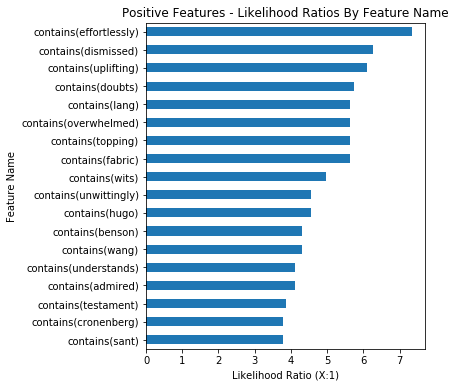

In [147]:
# find positive review index
positiveIndex = importantFeatures['featureValue']=='pos'
# set title name
titleName='Positive Features - Likelihood Ratios By Feature Name'
# create bar plot
importantFeatures['featureLikelihood'].loc[positiveIndex].sort_values(ascending=True).plot('barh',
    legend=False,figsize=(5,6),title=titleName)
# set x-label
plt.xlabel("Likelihood Ratio (X:1)")
# set y-label
plt.ylabel("Feature Name")

In [148]:
# show table
importantFeatures.loc[positiveIndex]

,featureValue,featureLikelihood
featureName,,
contains(effortlessly),pos,7.338010
contains(dismissed),pos,6.280279
contains(uplifting),pos,6.091399
contains(doubts),pos,5.751414
contains(overwhelmed),pos,5.619197
contains(topping),pos,5.619197
contains(fabric),pos,5.619197
contains(lang),pos,5.619197
contains(wits),pos,4.958115


For each of these 'high-importance' words, the reviews in the training sample have been examined to put the usage of the word in context.

#### contains(effortlessly)

In [149]:
searchWord='effortlessly'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|')
nReviews

20

In [150]:
searchResultReviews

,words,category,nWords,review,searchWord
32,"[it, must, be, some, sort, of, warped, critica...",pos,803,it must be some sort of warped critical nightm...,effortlessly
278,"["", he, ', s, back, ,, and, it, ', s, about, t...",pos,813,""" he ' s back , and it ' s about time . "" was ...",effortlessly
387,"[i, ', m, not, sure, who, the, genius, is, who...",neg,1258,i ' m not sure who the genius is who came up w...,effortlessly
464,"[for, this, review, and, more, ,, visit, clear...",pos,948,"for this review and more , visit clear illusio...",effortlessly
517,"[in, the, opening, shot, of, midnight, cowboy,...",pos,1450,"in the opening shot of midnight cowboy , we se...",effortlessly
594,"[synopsis, :, captain, picard, and, the, crew,...",pos,1416,synopsis : captain picard and the crew of the ...,effortlessly
653,"["", good, will, hunting, "", is, two, movies, i...",pos,354,""" good will hunting "" is two movies in one : a...",effortlessly
779,"[those, of, you, who, frequently, read, my, re...",pos,830,those of you who frequently read my reviews ar...,effortlessly
792,"[maybe, the, most, important, thing, about, th...",pos,1560,maybe the most important thing about this movi...,effortlessly
857,"[the, verdict, :, spine, -, chilling, drama, f...",pos,1060,the verdict : spine - chilling drama from horr...,effortlessly


In [151]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     2
pos    18
Name: words, dtype: int64

'Effortlessly' appears in 20 reviews and is used in both positive and negative reviews to convey the ease with which a character in the film, the cast, or the director accomplishes something. In everyday usage, the word 'effortlessly' has a positive connotation. Even in the negative reviews, this term is used to describe something positive. This term is not used sarcastically in any of the reviews.

#### contains(dismissed)

In [152]:
searchWord='dismissed'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

10

In [153]:
searchResultReviews

,words,category,nWords,review,searchWord
269,"[the, soldiers, of, three, kings, have, taken,...",pos,1143,the soldiers of three kings have taken their c...,dismissed
416,"["", crazy, /, beautiful, "", suffers, from, the...",pos,653,""" crazy / beautiful "" suffers from the damned ...",dismissed
587,"[capsule, :, a, ham, -, handed, and, over, /, ...",neg,1068,capsule : a ham - handed and over / underwritt...,dismissed
759,"[it, ', s, wednesday, ,, march, 27, ,, and, a,...",pos,1008,"it ' s wednesday , march 27 , and a murder inv...",dismissed
994,"[almost, a, full, decade, before, steven, spie...",pos,358,almost a full decade before steven spielberg '...,dismissed
1164,"[here, is, a, film, that, is, so, unexpected, ...",pos,1696,"here is a film that is so unexpected , so scar...",dismissed
1482,"[all, those, who, were, offended, by, there, '...",pos,763,all those who were offended by there ' s somet...,dismissed
1829,"[few, films, in, 1999, have, divided, the, cri...",pos,960,few films in 1999 have divided the critical co...,dismissed
1865,"[veteran, actor, clint, eastwood, has, never, ...",pos,576,veteran actor clint eastwood has never looked ...,dismissed
1893,"[i, feel, no, hesitation, in, saying, that, "",...",pos,977,"i feel no hesitation in saying that "" there ' ...",dismissed


In [154]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    9
Name: words, dtype: int64

'Dismissed' is generally used in the in-sample reviews in a way synonymous with 'underestimated' or 'underappreciated'. The term is only used in 10 reviews, 9 of which are positive.

#### contains(uplifting)

In [155]:
searchWord='uplifting'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

24

In [156]:
searchResultReviews

,words,category,nWords,review,searchWord
94,"[note, :, some, may, consider, portions, of, t...",pos,1279,note : some may consider portions of the follo...,uplifting
190,"[near, the, end, of, frank, capra, ', s, holid...",pos,462,near the end of frank capra ' s holiday classi...,uplifting
257,"[i, remember, hearing, about, this, film, when...",pos,686,i remember hearing about this film when it fir...,uplifting
297,"[the, happy, bastard, ', s, quick, movie, revi...",pos,555,the happy bastard ' s quick movie review analy...,uplifting
329,"[i, remember, making, a, pact, ,, right, after...",pos,839,"i remember making a pact , right after ` patch...",uplifting
342,"[_in, brief, :, _, this, film, needs, no, intr...",pos,1680,_in brief : _ this film needs no introduction ...,uplifting
351,"[plot, :, a, young, man, who, loves, heavy, me...",pos,718,plot : a young man who loves heavy metal music...,uplifting
422,"[in, a, flashback, ,, the, teenage, girl, in, ...",pos,852,"in a flashback , the teenage girl in the eccen...",uplifting
435,"[robert, altman, ', s, cookie, ', s, fortune, ...",pos,837,robert altman ' s cookie ' s fortune is that r...,uplifting
617,"[october, sky, is, a, rare, oddity, in, cinema...",pos,609,october sky is a rare oddity in cinema : a sel...,uplifting


In [157]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     3
pos    21
Name: words, dtype: int64

The word 'uplifting' appears in 24 reviews, 21 of which are categorized as 'positive'. In common usage, this word typically has a positive connotation. In the negative reviews, ‘uplifting’ is used sarcastically.

#### contains(doubts)

In [158]:
searchWord='doubts'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

16

In [159]:
searchResultReviews

,words,category,nWords,review,searchWord
275,"[let, me, start, off, by, saying, that, leadin...",pos,1576,let me start off by saying that leading up to ...,doubts
330,"[wow, !, what, a, movie, ., it, ', s, everythi...",pos,889,wow ! what a movie . it ' s everything a movie...,doubts
573,"[vegas, vacation, is, the, fourth, film, starr...",neg,449,vegas vacation is the fourth film starring che...,doubts
859,"[in, intolerance, ,, d, ., w, ., griffith, tol...",pos,1106,"in intolerance , d . w . griffith told four di...",doubts
1044,"[the, reunion, film, is, not, an, original, id...",pos,1403,the reunion film is not an original idea in an...,doubts
1136,"[i, don, ', t, appreciate, it, when, a, thrill...",neg,757,i don ' t appreciate it when a thriller manipu...,doubts
1139,"[this, "", dumb, "", cowboy, blondie, who, think...",pos,538,"this "" dumb "" cowboy blondie who thinks he is ...",doubts
1222,"[magnolia, left, me, relling, from, the, theat...",pos,868,"magnolia left me relling from the theatre , st...",doubts
1283,"[warning, :, if, you, actually, wish, to, see,...",pos,816,warning : if you actually wish to see the film...,doubts
1421,"[the, year, is, 1962, and, the, military, is, ...",pos,888,the year is 1962 and the military is conductin...,doubts


In [160]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     2
pos    14
Name: words, dtype: int64

The word, 'doubts', is used in several ways in the reviews of the training set. In some cases, characters with 'doubts' represent a struggle related to the plot and sometimes represent a compelling internal struggle. In other cases, the word is used to describe a viewer's response to a part of a film, but generally the reviewer indicates that their doubts are unfounded or resolved in a positive way.

#### contains(overwhelmed)

In [161]:
searchWord='overwhelmed'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

9

In [162]:
searchResultReviews

,words,category,nWords,review,searchWord
29,"[who, would, have, thought, ?, jim, carrey, do...",pos,818,who would have thought ? jim carrey does drama...,overwhelmed
156,"[stendhal, ', s, syndrome, :, a, condition, wh...",pos,722,"stendhal ' s syndrome : a condition where , in...",overwhelmed
422,"[in, a, flashback, ,, the, teenage, girl, in, ...",pos,852,"in a flashback , the teenage girl in the eccen...",overwhelmed
656,"[the, general, ', s, daughter, will, probably,...",neg,787,the general ' s daughter will probably be the ...,overwhelmed
712,"["", when, will, the, devil, take, me, ?, "", he...",pos,810,""" when will the devil take me ? "" he asks rhet...",overwhelmed
793,"[steven, spielberg, is, now, considered, as, o...",pos,1263,steven spielberg is now considered as one of t...,overwhelmed
1163,"[what, a, great, film, ., what, a, stunning, ,...",pos,1011,"what a great film . what a stunning , touching...",overwhelmed
1170,"[alien, 3, is, the, only, alien, film, i, have...",pos,2105,alien 3 is the only alien film i have seen in ...,overwhelmed
1673,"[in, december, of, 1996, ,, a, little, movie, ...",pos,1572,"in december of 1996 , a little movie called "" ...",overwhelmed


In [163]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    8
Name: words, dtype: int64

The word 'overwhelmed' is used to describe the emotional responses of both viewers of the film and characters in the film. Although this word typically has a negative connotation, the word is generally used in reviews to describe compelling struggles. This word only appears in 9 reviews.

#### contains(topping)

In [164]:
searchWord='topping'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

9

In [165]:
searchResultReviews

,words,category,nWords,review,searchWord
200,"[a, month, ago, i, wrote, that, speed, 2, was,...",neg,225,a month ago i wrote that speed 2 was the worst...,topping
754,"[i, was, pleasantly, surprised, by, this, film...",pos,1316,i was pleasantly surprised by this film . with...,topping
1033,"[when, i, first, saw, the, previews, for, ron,...",pos,750,when i first saw the previews for ron howard '...,topping
1147,"[with, the, success, of, the, surprise, hit, a...",pos,1501,"with the success of the surprise hit alien , d...",topping
1270,"[you, may, not, have, heard, of, lucas, ,, or,...",pos,1023,"you may not have heard of lucas , or if you ha...",topping
1665,"["", living, out, loud, ,, "", is, the, type, of...",pos,814,""" living out loud , "" is the type of motion pi...",topping
1695,"[note, :, some, may, consider, portions, of, t...",pos,1153,note : some may consider portions of the follo...,topping
1749,"[written, by, john, grisham, and, robert, altm...",pos,1373,written by john grisham and robert altman ( as...,topping
1782,"[note, :, some, may, consider, portions, of, t...",pos,1921,note : some may consider portions of the follo...,topping


In [166]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    8
Name: words, dtype: int64

As a synonym for ‘surpassing’, it is not surprising that the word, 'topping' appears predominantly in positive reviews.

#### contains(fabric)

In [167]:
searchWord='fabric'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

9

In [168]:
searchResultReviews

,words,category,nWords,review,searchWord
27,"[there, ', s, more, to, a, quilt, than, fabric...",pos,799,there ' s more to a quilt than fabric and thre...,fabric
174,"[here, ', s, a, word, analogy, :, amistad, is,...",pos,1467,here ' s a word analogy : amistad is to the lo...,fabric
349,"[at, first, glance, ,, it, appears, that, the,...",pos,1019,"at first glance , it appears that the home alo...",fabric
434,"[unzipped, is, a, cinematic, portrait, of, isa...",pos,603,unzipped is a cinematic portrait of isaac mizr...,fabric
736,"[i, ', ve, always, been, told, that, there, ar...",pos,582,i ' ve always been told that there are two thi...,fabric
827,"[in, arguably, the, most, anticipated, movie, ...",pos,463,in arguably the most anticipated movie this ce...,fabric
1161,"[porter, stoddard, (, warren, beatty, ), is, a...",neg,824,porter stoddard ( warren beatty ) is a success...,fabric
1380,"[set, in, the, late, 80, ', s, at, the, height...",pos,1326,set in the late 80 ' s at the height of yuppie...,fabric
1850,"[with, a, team, of, 200, graphic, artists, and...",pos,711,with a team of 200 graphic artists and animato...,fabric


In [169]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    8
Name: words, dtype: int64

Although the word, 'fabric' only appears in 9 reviews, in common usage this word does not have a positive or negative connotation. This word seems unlikely to have predictive power out-of-sample.

#### contains(lang)

In [170]:
searchWord='lang'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

9

In [171]:
searchResultReviews

,words,category,nWords,review,searchWord
937,"[cinema, has, been, around, for, about, a, hun...",pos,1407,cinema has been around for about a hundred yea...,lang
1022,"[niagara, niagara, (, r, ), bob, gosse, ', s, ...",pos,411,niagara niagara ( r ) bob gosse ' s niagara ni...,lang
1041,"[hollywood, has, really, done, the, whole, dra...",pos,887,hollywood has really done the whole dracula th...,lang
1427,"[a, big, surprise, to, me, ., the, good, trail...",pos,407,a big surprise to me . the good trailer had hi...,lang
1444,"[most, movies, seem, to, release, a, third, mo...",pos,376,most movies seem to release a third movie just...,lang
1479,"[i, wish, i, could, say, that, there, is, some...",pos,1069,i wish i could say that there is something mor...,lang
1743,"[i, should, have, known, ,, damn, it, ,, i, sh...",neg,1316,"i should have known , damn it , i should have ...",lang
1752,"[waiting, at, the, train, station, near, the, ...",pos,740,waiting at the train station near the beginnin...,lang
1798,"[fritz, lang, ', s, first, american, film, sin...",pos,1025,fritz lang ' s first american film since leavi...,lang


In [172]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    8
Name: words, dtype: int64

Fritz Lang - an Austrian film director, producer and screenwriter - directed popular films of the silent era (including Metropolis). James "Clubber" Lang is the main antagonist in Rocky III played by Mr. T. Most of the 8 positive reviews reference 'Fritz Lang'. The negative review has a neutral reference to K.D. Lang.

#### contains(wits)

In [173]:
searchWord='wits'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

8

In [174]:
searchResultReviews

,words,category,nWords,review,searchWord
275,"[let, me, start, off, by, saying, that, leadin...",pos,1576,let me start off by saying that leading up to ...,wits
425,"[ever, watch, a, very, young, child, try, and,...",neg,651,ever watch a very young child try and tell a j...,wits
462,"["", the, fugitive, "", is, probably, one, of, t...",pos,779,""" the fugitive "" is probably one of the greate...",wits
708,"[quentin, tarantino, seems, to, have, a, knack...",pos,1482,quentin tarantino seems to have a knack for gi...,wits
1521,"[the, film, starts, out, with, a, creepy, open...",pos,628,the film starts out with a creepy opening sequ...,wits
1791,"[plot, :, a, dude, and, his, brother, are, dri...",pos,804,plot : a dude and his brother are driving cros...,wits
1881,"[by, phil, curtolo, mel, gibson, (, braveheart...",pos,405,by phil curtolo mel gibson ( braveheart ) gave...,wits
1884,"[elmore, leonard, has, quickly, become, one, o...",pos,543,elmore leonard has quickly become one of holly...,wits


In [175]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    7
Name: words, dtype: int64

The word, 'wits', is generally used in the training set reviews to positively describe characters in the film being reviewed. This word appears only 8 times in the training set. Typically, the word 'wit' has a positive connation. In the single negative review, the absence of characters with 'wit' is part of the negative critique.

#### contains(unwittingly)

In [176]:
searchWord='unwittingly'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

13

In [177]:
searchResultReviews

,words,category,nWords,review,searchWord
95,"[with, storytelling, this, compelling, ,, who,...",pos,497,"with storytelling this compelling , who needs ...",unwittingly
1075,"[expand, the, final, fifteen, minutes, of, hom...",pos,370,expand the final fifteen minutes of home alone...,unwittingly
1213,"[i, ', m, not, quite, sure, what, to, say, abo...",pos,1241,i ' m not quite sure what to say about mars at...,unwittingly
1217,"[jackie, brown, entered, theaters, with, littl...",pos,1394,jackie brown entered theaters with little fanf...,unwittingly
1372,"[you, ', ve, got, mail, is, a, timely, romance...",pos,495,you ' ve got mail is a timely romance for this...,unwittingly
1399,"[the, truman, show, (, paramount, pictures, ),...",pos,653,the truman show ( paramount pictures ) running...,unwittingly
1456,"[he, has, spent, his, entire, life, in, an, aw...",pos,1064,he has spent his entire life in an awful littl...,unwittingly
1509,"[in, "", the, astronaut, ', s, wife, ,, "", char...",neg,583,"in "" the astronaut ' s wife , "" charlize thero...",unwittingly
1511,"[once, upon, a, time, a, solitary, ogre, named...",pos,897,once upon a time a solitary ogre named shrek (...,unwittingly
1515,"[tbwp, is, probably, the, single, most, profit...",pos,413,tbwp is probably the single most profitable fi...,unwittingly


In [178]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     2
pos    11
Name: words, dtype: int64

The word, 'unwittingly', appears in 11 positive reviews, and is used to denote innocence or something accidental. The term is generally associated with likeable characters. Even in the negative reviews, the word is used to describe characters positively.

#### contains(hugo)

In [179]:
searchWord='hugo'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

13

In [180]:
searchResultReviews

,words,category,nWords,review,searchWord
46,"[various, films, seen, at, the, seattle, film,...",neg,1490,various films seen at the seattle film festiva...,hugo
197,"[plot, outline, -, wendy, (, samantha, press, ...",neg,736,"plot outline - wendy ( samantha press ) , a ja...",hugo
332,"[modern, audiences, are, more, likely, to, be,...",pos,529,modern audiences are more likely to be familia...,hugo
437,"[the, calendar, year, has, not, even, reached,...",pos,795,the calendar year has not even reached its mid...,hugo
454,"[plot, :, odin, is, a, great, high, school, ba...",pos,838,plot : odin is a great high school basketball ...,hugo
758,"[a, welcome, cinematic, trend, over, the, past...",pos,766,a welcome cinematic trend over the past couple...,hugo
779,"[those, of, you, who, frequently, read, my, re...",pos,830,those of you who frequently read my reviews ar...,hugo
899,"[if, you, had, a, chance, to, create, a, genet...",pos,1226,if you had a chance to create a genetically pe...,hugo
1046,"[it, ', s, an, interesting, premise, ., our, r...",pos,1140,it ' s an interesting premise . our reality is...,hugo
1125,"[while, watching, "", shallow, grave, ,, "", i, ...",pos,878,"while watching "" shallow grave , "" i found mys...",hugo


In [181]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     2
pos    11
Name: words, dtype: int64

The name, 'Hugo', appears in 13 reviews, 11 of which or positive. No pattern is evident. This feature seems spurious.

#### contains(benson)

In [182]:
searchWord='benson'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

7

In [183]:
searchResultReviews

,words,category,nWords,review,searchWord
154,"[eight, years, after, its, release, ,, disney,...",pos,844,"eight years after its release , disney has dec...",benson
203,"[note, :, some, may, consider, portions, of, t...",pos,1554,note : some may consider portions of the follo...,benson
519,"["", it, ', s, not, good, to, know, too, much, ...",pos,563,""" it ' s not good to know too much about someo...",benson
522,"[when, i, first, heard, that, disney, ', s, ne...",pos,1459,when i first heard that disney ' s next animat...,benson
689,"[you, ', ve, got, to, love, disney, ., no, mat...",pos,1403,you ' ve got to love disney . no matter what t...,benson
1458,"[in, october, of, 1997, ,, audiences, were, da...",pos,957,"in october of 1997 , audiences were dazzled by...",benson
1533,"["", flubber, "", is, the, second, best, example...",neg,1162,""" flubber "" is the second best example of how ...",benson


In [184]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    6
Name: words, dtype: int64

The name, 'Benson', appears in just 7 reviews, 6 of which or positive. No pattern is evident. This feature seems spurious.

#### contains(wang)

In [185]:
searchWord='wang'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

7

In [186]:
searchResultReviews

,words,category,nWords,review,searchWord
19,"[touchstone, pictures, and, spyglass, entertai...",pos,1352,touchstone pictures and spyglass entertainment...,wang
615,"[the, laserman, :, somehow, the, title, of, wr...",pos,971,the laserman : somehow the title of writer - d...,wang
895,"[if, the, current, trends, of, hollywood, film...",pos,858,if the current trends of hollywood filmmaking ...,wang
924,"[the, title, is, taken, from, the, writings, o...",neg,833,the title is taken from the writings of ralph ...,wang
1312,"[note, :, some, may, consider, portions, of, t...",pos,851,note : some may consider portions of the follo...,wang
1359,"[as, i, walked, out, of, crouching, tiger, ,, ...",pos,672,"as i walked out of crouching tiger , hidden dr...",wang
1525,"[synopsis, :, in, this, cultural, exploration,...",pos,342,"synopsis : in this cultural exploration , a ch...",wang


In [187]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    1
pos    6
Name: words, dtype: int64

The surname, 'Wang', is found in 7 reviews, 6 of which are positive. No pattern is evident. This feature seems spurious.

#### contains(understands)

In [188]:
searchWord='understands'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

17

In [189]:
searchResultReviews

,words,category,nWords,review,searchWord
110,"[driving, miss, daisy, takes, its, sweet, time...",pos,1039,driving miss daisy takes its sweet time to tel...,understands
162,"[sandra, bullock, in, high, heels, and, wieldi...",neg,933,sandra bullock in high heels and wielding a ch...,understands
294,"[roberto, benigni, is, a, clown, in, the, trad...",pos,742,roberto benigni is a clown in the tradition of...,understands
431,"[garry, shandling, makes, his, long, overdue, ...",pos,727,garry shandling makes his long overdue starrin...,understands
520,"[while, watching, loser, ,, it, occurred, to, ...",neg,1012,"while watching loser , it occurred to me that ...",understands
564,"[the, uncompromising, nudity, bared, throughou...",pos,880,the uncompromising nudity bared throughout pet...,understands
566,"[all, through, its, production, and, into, the...",neg,888,all through its production and into the early ...,understands
735,"["", the, tailor, of, panama, "", is, a, differe...",pos,907,""" the tailor of panama "" is a different kind o...",understands
794,"[the, long, and, illustrious, career, of, robi...",pos,586,the long and illustrious career of robin willi...,understands
1008,"[bill, condon, ', s, "", gods, and, monsters, ""...",pos,1113,"bill condon ' s "" gods and monsters "" is a fas...",understands


In [190]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     3
pos    14
Name: words, dtype: int64

The word, 'understands', has a positive connotation. In the negative reviews, the word is used in a way to indicate that a character behaves in an implausible way.

#### contains(admired)

In [191]:
searchWord='admired'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

17

In [192]:
searchResultReviews

,words,category,nWords,review,searchWord
8,"[this, is, one, of, the, most, funny, and, ent...",pos,1008,this is one of the most funny and entertaining...,admired
44,"[you, ', ve, seen, this, moment, before, ,, re...",pos,641,"you ' ve seen this moment before , recently : ...",admired
300,"[this, is, a, film, that, i, was, inclined, to...",neg,611,this is a film that i was inclined to like at ...,admired
450,"[i, can, hear, the, question, already, ., what...",pos,903,i can hear the question already . what on eart...,admired
596,"[my, opinion, on, a, film, can, be, easily, sw...",neg,1434,my opinion on a film can be easily swayed by t...,admired
624,"[for, a, movie, about, disco, -, era, excess, ...",pos,1047,"for a movie about disco - era excess , "" 54 "" ...",admired
642,"[along, his, carreer, ,, mel, gibson, has, col...",pos,596,"along his carreer , mel gibson has collected s...",admired
1100,"[poster, boy, for, co, -, dependency, needs, p...",neg,1064,poster boy for co - dependency needs patching ...,admired
1102,"[oh, god, how, many, john, grisham, lawyer, fi...",pos,2064,oh god how many john grisham lawyer films we h...,admired
1258,"[if, you, ', re, the, type, of, person, who, g...",pos,523,if you ' re the type of person who goes on the...,admired


In [193]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     3
pos    14
Name: words, dtype: int64

The word, 'admired', is used in 17 reviews, 14 of which are positive. It has a positive connotation in everyday usage.

#### contains(testament)

In [194]:
searchWord='testament'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

21

In [195]:
searchResultReviews

,words,category,nWords,review,searchWord
106,"[nosferatu, the, vampyre, (, germany, 1979, ),...",pos,845,nosferatu the vampyre ( germany 1979 ) a film ...,testament
205,"["", you, leave, little, notes, on, my, pillow,...",pos,469,""" you leave little notes on my pillow . i told...",testament
245,"["", tina, !, !, !, fetch, me, the, axe, !, !, ...",neg,838,""" tina ! ! ! fetch me the axe ! ! ! "" a favour...",testament
421,"[martin, scorsese, ', s, triumphant, adaptatio...",pos,733,martin scorsese ' s triumphant adaptation of e...,testament
538,"[late, in, down, to, you, ,, the, lead, female...",neg,780,"late in down to you , the lead female characte...",testament
559,"[true, faith, and, its, expression, through, o...",pos,1241,true faith and its expression through organize...,testament
762,"[i, suppose, an, argument, could, be, made, th...",pos,1519,i suppose an argument could be made that toy s...,testament
784,"[in, some, regards, ,, making, a, movie, is, l...",pos,649,"in some regards , making a movie is like tryin...",testament
836,"[it, is, often, said, by, his, fans, that, hal...",pos,566,it is often said by his fans that hal hartley ...,testament
902,"[toward, the, bottom, of, the, ', 80s, action,...",neg,573,toward the bottom of the ' 80s action movie ba...,testament


In [196]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg     4
pos    17
Name: words, dtype: int64

'Testament' is used in in 21 reviews, 17 of which are positive. Given that this word has a rather neutral connotation, it is surprising that this word is found so often in positive reviews.

#### contains(cronenberg)

In [197]:
searchWord='cronenberg'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

11

In [198]:
searchResultReviews

,words,category,nWords,review,searchWord
118,"[david, cronenberg, presents, us, with, anothe...",pos,983,david cronenberg presents us with another stra...,cronenberg
173,"["", last, night, "", could, have, an, "", aka, ""...",pos,807,""" last night "" could have an "" aka "" tagged on...",cronenberg
184,"[part, one, of, "", the, strangest, movies, eve...",pos,751,"part one of "" the strangest movies ever made ""...",cronenberg
509,"[i, ', m, not, really, sure, what, to, think, ...",pos,1520,"i ' m not really sure what to think about "" cr...",cronenberg
577,"[capsule, :, the, world, will, come, to, an, e...",pos,434,capsule : the world will come to an end at mid...,cronenberg
778,"[not, since, oliver, stone, ', s, natural, bor...",pos,811,not since oliver stone ' s natural born killer...,cronenberg
786,"[well, i, ', ll, be, damned, ., ., ., the, can...",pos,517,well i ' ll be damned . . . the canadians can ...,cronenberg
1076,"[note, :, some, may, consider, portions, of, t...",pos,1178,note : some may consider portions of the follo...,cronenberg
1213,"[i, ', m, not, quite, sure, what, to, say, abo...",pos,1241,i ' m not quite sure what to say about mars at...,cronenberg
1463,"["", we, are, grateful, that, we, have, the, so...",neg,944,""" we are grateful that we have the songs of gr...",cronenberg


In [199]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    2
pos    9
Name: words, dtype: int64

David 'Cronenberg' is a critically-acclaimed – albeit controversial – Canadian director, screenwriter, and actor famous for gory science fiction and horror films. Of the 11 reviews in the training set, 9 are positive.

#### contains(sant)

In [200]:
searchWord='sant'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

11

In [201]:
searchResultReviews

,words,category,nWords,review,searchWord
638,"[i, have, little, against, remakes, and, updat...",neg,762,i have little against remakes and updates of o...,sant
653,"["", good, will, hunting, "", is, two, movies, i...",pos,354,""" good will hunting "" is two movies in one : a...",sant
746,"[there, are, certain, people, in, the, world, ...",pos,1327,there are certain people in the world who have...,sant
801,"[note, :, some, may, consider, portions, of, t...",pos,2879,note : some may consider portions of the follo...,sant
939,"[look, !, the, new, version, of, "", psycho, "",...",neg,776,"look ! the new version of "" psycho "" came out ...",sant
941,"[every, year, ,, hollywood, crowns, a, new, "",...",pos,724,"every year , hollywood crowns a new "" it boy ""...",sant
955,"[in, essence, ,, good, will, hunting, is, an, ...",pos,1003,"in essence , good will hunting is an ordinary ...",sant
1026,"[i, must, admit, that, i, was, a, tad, skeptic...",pos,966,"i must admit that i was a tad skeptical of "" g...",sant
1032,"[in, brief, :, best, bleak, comedy, film, sinc...",pos,1042,in brief : best bleak comedy film since heathe...,sant
1481,"[jay, and, silent, bob, strike, back, ,, kevin...",pos,820,"jay and silent bob strike back , kevin smith '...",sant


In [202]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    2
pos    9
Name: words, dtype: int64

Gus Van 'Sant' is an award-winning American film director, screenwriter, painter, photographer, musician and author, perhaps best known for his film ‘Good Will Hunting’. He has earned acclaim as both a mainstream and an independent filmmaker. Of the 11 reviews in the training set, 9 are positive.

Plot the likelihood ratios by negative feature name:

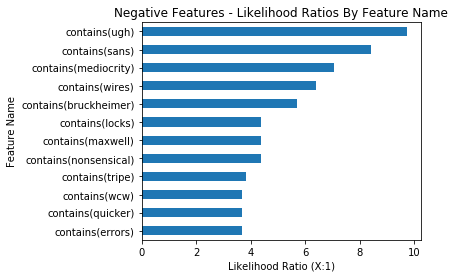

In [203]:
# find negative review index
negativeIndex = importantFeatures['featureValue']=='neg'
# set title name
titleName='Negative Features - Likelihood Ratios By Feature Name'
# create bar plot
importantFeatures['featureLikelihood'].loc[negativeIndex].sort_values(ascending=True).plot('barh',
    legend=False,figsize=(5,4),title=titleName)
# set x-label
plt.xlabel("Likelihood Ratio (X:1)")
# set y-label
plt.ylabel("Feature Name")

In [204]:
# show the table
importantFeatures.loc[negativeIndex]

,featureValue,featureLikelihood
featureName,,
contains(ugh),neg,9.748328
contains(sans),neg,8.403731
contains(mediocrity),neg,7.059134
contains(wires),neg,6.386836
contains(bruckheimer),neg,5.714537
contains(nonsensical),neg,4.369940
contains(maxwell),neg,4.369940
contains(locks),neg,4.369940
contains(tripe),neg,3.832101


#### contains(ugh)


In [205]:
searchWord='ugh'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

15

In [206]:
searchResultReviews

,words,category,nWords,review,searchWord
48,"[okay, ,, i, just, don, ', t, know, why, ,, bu...",neg,760,"okay , i just don ' t know why , but i seem to...",ugh
318,"[*, *, *, the, following, review, contains, sp...",neg,2271,* * * the following review contains spoilers *...,ugh
361,"[plot, :, a, down, -, and, -, out, girl, moves...",neg,981,plot : a down - and - out girl moves in with s...,ugh
444,"[ugh, ., that, about, sums, this, movie, up, ....",neg,469,"ugh . that about sums this movie up . just , u...",ugh
459,"[so, what, do, you, get, when, you, mix, toget...",neg,862,so what do you get when you mix together plot ...,ugh
645,"[are, you, like, me, ?, do, you, get, annoyed,...",neg,724,are you like me ? do you get annoyed seeing pe...,ugh
775,"[plot, :, a, separated, ,, glamorous, ,, holly...",neg,872,"plot : a separated , glamorous , hollywood cou...",ugh
810,"[woof, !, too, bad, that, leap, of, faith, was...",neg,535,woof ! too bad that leap of faith was the titl...,ugh
967,"[one, of, the, contributors, to, the, destruct...",neg,815,one of the contributors to the destruction of ...,ugh
1018,"[the, most, interesting, part, of, "", can, ', ...",neg,1619,"the most interesting part of "" can ' t hardly ...",ugh


In [207]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    14
pos     1
Name: words, dtype: int64

'Ugh' is found in 15 reviews, 14 of which are negative. This is very clearly a negative 'word'.

#### contains(sans)


In [208]:
searchWord='sans'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

13

In [209]:
searchResultReviews

,words,category,nWords,review,searchWord
86,"[it, seemed, wholly, appropriate, that, at, a,...",pos,718,it seemed wholly appropriate that at a weekend...,sans
99,"[what, hath, kevin, williamson, wrought, ?, wh...",neg,829,what hath kevin williamson wrought ? while the...,sans
170,"[capsule, :, combine, one, quart, of, raiders,...",neg,632,capsule : combine one quart of raiders of the ...,sans
210,"[to, sum, the, entire, film, "", 54, "", up, in,...",neg,650,"to sum the entire film "" 54 "" up in one senten...",sans
402,"[when, a, pair, of, films, from, the, same, di...",neg,625,when a pair of films from the same director ge...,sans
670,"[underwater, science, fiction, stays, submerge...",neg,1104,underwater science fiction stays submerged sph...,sans
688,"["", some, houses, are, born, bad, ,, "", goes, ...",neg,818,""" some houses are born bad , "" goes the haunti...",sans
743,"[for, about, twenty, minutes, into, mission, i...",neg,1517,for about twenty minutes into mission impossib...,sans
991,"[there, ', s, a, scene, early, on, in, "", jawb...",neg,616,"there ' s a scene early on in "" jawbreaker "" w...",sans
1124,"[despite, its, exceedingly, well, -, done, vis...",neg,996,despite its exceedingly well - done visual eff...,sans


In [210]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    12
pos     1
Name: words, dtype: int64

Despite the neutral connotation, 'sans' - the French word for 'without' - is found in 13 reviews, 12 of which are negative.

#### contains(mediocrity)


In [211]:
searchWord='mediocrity'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

11

In [212]:
searchResultReviews

,words,category,nWords,review,searchWord
52,"[`, the, bachelor, ', is, one, of, the, best, ...",neg,826,` the bachelor ' is one of the best terrible m...,mediocrity
143,"[i, ', ve, noticed, something, lately, that, i...",pos,807,i ' ve noticed something lately that i ' ve ne...,mediocrity
260,"[when, the, mediums, in, question, are, video,...",neg,748,when the mediums in question are video game an...,mediocrity
261,"[there, are, some, pretty, impressive, stars, ...",neg,1043,there are some pretty impressive stars in lost...,mediocrity
506,"[in, the, mid, -, 1980s, ,, following, the, sp...",neg,514,"in the mid - 1980s , following the splendid de...",mediocrity
797,"[in, a, typical, cinematic, high, school, ,, t...",neg,505,"in a typical cinematic high school , the footb...",mediocrity
906,"[when, i, was, nine, ,, i, started, buying, th...",neg,563,"when i was nine , i started buying the coolest...",mediocrity
1100,"[poster, boy, for, co, -, dependency, needs, p...",neg,1064,poster boy for co - dependency needs patching ...,mediocrity
1200,"[a, remake, of, the, 1978, warren, beatty, veh...",neg,586,"a remake of the 1978 warren beatty vehicle "" h...",mediocrity
1679,"[ladies, and, gentlemen, ,, payback, is, the, ...",neg,621,"ladies and gentlemen , payback is the most exp...",mediocrity


In [213]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    10
pos     1
Name: words, dtype: int64

'Mediocrity' clearly has a negative connotation. Of 11 reviews containing this term, 10 are negative.

#### contains(wires)


In [214]:
searchWord='wires'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

10

In [215]:
searchResultReviews

,words,category,nWords,review,searchWord
59,"[even, the, best, comic, actor, is, at, the, m...",neg,753,even the best comic actor is at the mercy of h...,wires
82,"[by, starring, in, amy, heckerling, ', s, "", c...",neg,787,"by starring in amy heckerling ' s "" clueless ""...",wires
184,"[part, one, of, "", the, strangest, movies, eve...",pos,751,"part one of "" the strangest movies ever made ""...",wires
318,"[*, *, *, the, following, review, contains, sp...",neg,2271,* * * the following review contains spoilers *...,wires
542,"[when, you, ', ve, run, out, of, old, tv, show...",neg,928,when you ' ve run out of old tv shows to turn ...,wires
576,"[i, looked, at, the, "", internet, movie, datab...",neg,805,"i looked at the "" internet movie database "" ' ...",wires
978,"["", virus, "", is, a, monster, movie, without, ...",neg,671,""" virus "" is a monster movie without a monster...",wires
1364,"[jet, li, busted, onto, the, american, action,...",neg,762,jet li busted onto the american action movie s...,wires
1402,"[i, ', ve, never, written, a, review, for, a, ...",neg,1690,i ' ve never written a review for a movie i ha...,wires
1530,"[after, seeing, blaze, and, driving, miss, dai...",neg,909,"after seeing blaze and driving miss daisy , i ...",wires


In [216]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    9
pos    1
Name: words, dtype: int64

The word, 'wires', appears in 10 reviews, 9 of which are negative. No pattern is evident. This feature seems spurious.

#### contains(bruckheimer)

In [217]:
searchWord='bruckheimer'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

9

In [218]:
searchResultReviews

,words,category,nWords,review,searchWord
16,"[director, dominic, sena, (, who, made, the, h...",pos,754,director dominic sena ( who made the highly un...,bruckheimer
47,"[the, comet, -, disaster, flick, is, a, disast...",neg,241,the comet - disaster flick is a disaster alrig...,bruckheimer
167,"[warner, brothers, ;, rated, pg, -, 13, (, mil...",neg,1015,warner brothers ; rated pg - 13 ( mild violenc...,bruckheimer
215,"[for, a, good, ten, years, or, so, ,, super, c...",neg,462,"for a good ten years or so , super cool chow y...",bruckheimer
654,"[if, i, were, to, plot, a, graph, of, year, ag...",neg,928,if i were to plot a graph of year against movi...,bruckheimer
875,"[nicolas, cage, comes, up, with, an, ingenious...",neg,873,nicolas cage comes up with an ingenious surviv...,bruckheimer
1313,"[the, stereotypical, american, male, has, an, ...",neg,925,the stereotypical american male has an undenia...,bruckheimer
1413,"[by, -, the, -, numbers, :, a, film, which, in...",neg,999,by - the - numbers : a film which introduces c...,bruckheimer
1824,"[new, address, ., same, old, attitude, ., don,...",neg,1167,new address . same old attitude . don ' t forg...,bruckheimer


In [219]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    8
pos    1
Name: words, dtype: int64

Jerome Bruckheimer - an American film and television producer is well-known television series (CSI: Crime Scene Investigation, CSI: Miami, CSI: NY, Without a Trace, and Cold Case), and a host of films (Flashdance, Top Gun, The Rock, Con Air, Armageddon, Kangaroo Jack, Enemy of the State, Black Hawk Down, Pearl Harbor, and the Beverly Hills Cop, Bad Boys, Pirates of the Caribbean and National Treasure franchises). Despite box-office success, many of Bruckheimer's movies are widely criticized by reviewers.

Of the 9 reviews in the training set that contain the word 'Bruckheimer', only one is positive. Of the 8 negative reviews, 3 are about the film 'Armageddon'. The other negative reviews mention 'Con Air', 'Gone in 60 Seconds', 'By-The-Numbers', 'Message In A Bottle' and 'Replacement Killers'.

Although the reviews in the training set are overwhelmingly negative, 9 mentions in 1900 is a pretty small sample.

#### contains(nonsensical)

In [220]:
searchWord='nonsensical'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

7

In [221]:
searchResultReviews

,words,category,nWords,review,searchWord
253,"[steve, martin, took, an, extended, vacation, ...",pos,1012,steve martin took an extended vacation from al...,nonsensical
315,"["", there, will, be, another, ,, "", the, ads, ...",neg,891,""" there will be another , "" the ads for this s...",nonsensical
337,"[if, you, ', ve, been, following, william, fic...",neg,497,if you ' ve been following william fichtner ' ...,nonsensical
382,"[reindeer, games, is, easily, the, worst, of, ...",neg,1503,reindeer games is easily the worst of the thre...,nonsensical
722,"[in, the, year, 2029, ,, captain, leo, davidso...",neg,733,"in the year 2029 , captain leo davidson ( mark...",nonsensical
992,"["", the, world, on, land, --, it, ', s, just, ...",neg,832,""" the world on land -- it ' s just too big for...",nonsensical
1669,"[when, i, arrived, in, paris, in, june, ,, 199...",neg,532,"when i arrived in paris in june , 1992 , i was...",nonsensical


In [222]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    6
pos    1
Name: words, dtype: int64

'Nonsensical' is found in 7 reviews, 6 of which are negative. This term is usually used to convey something negative.

#### contains(maxwell)

In [223]:
searchWord='maxwell'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)n
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

7

In [224]:
searchResultReviews

,words,category,nWords,review,searchWord
2,"[the, real, blonde, (, r, ), a, woman, ', s, f...",neg,680,"the real blonde ( r ) a woman ' s face , an ar...",maxwell
50,"[in, the, james, bond, film, "", diamonds, are,...",neg,752,"in the james bond film "" diamonds are forever ...",maxwell
616,"[it, may, seem, weird, to, begin, a, film, abo...",pos,2164,it may seem weird to begin a film about glam r...,maxwell
1087,"[whether, you, like, the, beatles, or, not, ,,...",neg,811,"whether you like the beatles or not , nobody w...",maxwell
1355,"[hav, plenty, ,, as, we, are, told, in, the, b...",neg,411,"hav plenty , as we are told in the beginning a...",maxwell
1523,"[tom, dicillo, directs, this, superficial, com...",neg,447,tom dicillo directs this superficial comedy ab...,maxwell
1524,"["", mandingo, "", has, traditionally, been, see...",neg,1512,""" mandingo "" has traditionally been seen as on...",maxwell


In [225]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    6
pos    1
Name: words, dtype: int64

'Maxwell' found in names that appear in 7 different reviews, 6 of which are negative. This feature appears to be spurious.

#### contains(locks)

In [226]:
searchWord='locks'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

7

In [227]:
searchResultReviews

,words,category,nWords,review,searchWord
82,"[by, starring, in, amy, heckerling, ', s, "", c...",neg,787,"by starring in amy heckerling ' s "" clueless ""...",locks
277,"[to, put, it, bluntly, ,, ed, wood, would, hav...",neg,586,"to put it bluntly , ed wood would have been pr...",locks
571,"[ripe, with, explosions, ,, mass, death, and, ...",neg,618,"ripe with explosions , mass death and really w...",locks
1301,"[the, spy, game, is, up, ., you, can, thank, c...",neg,742,the spy game is up . you can thank charlie ' s...,locks
1553,"[say, ,, tell, me, if, you, ', ve, seen, this,...",neg,239,"say , tell me if you ' ve seen this before : a...",locks
1581,"[one, of, the, funniest, carry, on, movies, an...",pos,518,one of the funniest carry on movies and the th...,locks
1604,"[miramax, "", disinvited, "", on, -, line, media...",neg,1099,"miramax "" disinvited "" on - line media from pr...",locks


In [228]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    6
pos    1
Name: words, dtype: int64

The word, 'locks', is used in 7 reviews, 6 of which are negative. No pattern is evident. This feature seems spurious.

#### contains(tripe)

In [229]:
searchWord='tripe'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

11

In [230]:
searchResultReviews

,words,category,nWords,review,searchWord
28,"[let, me, open, this, one, with, a, confession...",pos,1613,let me open this one with a confession : i lov...,tripe
704,"[after, enduring, mariah, carey, ', s, film, d...",neg,753,"after enduring mariah carey ' s film debut , g...",tripe
835,"[capsule, :, an, insult, ., a, stupid, and, in...",neg,882,capsule : an insult . a stupid and incompetent...,tripe
970,"[chris, tucker, is, one, of, those, guys, you,...",neg,889,chris tucker is one of those guys you immediat...,tripe
1057,"[the, realm, of, science, fiction, has, always...",neg,1369,the realm of science fiction has always been a...,tripe
1064,"[mickey, mouse, had, better, watch, his, back,...",pos,761,mickey mouse had better watch his back -- ther...,tripe
1104,"[come, on, hollywood, ,, surprise, me, ., stop...",neg,630,"come on hollywood , surprise me . stop giving ...",tripe
1174,"[if, anything, ,, "", stigmata, "", should, be, ...",neg,1701,"if anything , "" stigmata "" should be taken as ...",tripe
1344,"[one, of, my, brother, ', s, favorite, movies,...",neg,675,one of my brother ' s favorite movies is h . b...,tripe
1452,"[you, don, ', t, need, to, have, seen, the, or...",neg,682,"you don ' t need to have seen the original "" s...",tripe


In [231]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    9
pos    2
Name: words, dtype: int64

'Tripe' is used in 11 reviews, 9 of which are negative. This word clearly has a negative connotation.

#### contains(errors)

In [232]:
searchWord='errors'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

6

In [233]:
searchResultReviews

,words,category,nWords,review,searchWord
116,"[from, a, major, league, baseball, radio, broa...",neg,1213,"from a major league baseball radio broadcast ,...",errors
164,"[when, i, first, heard, about, scream, in, 199...",pos,761,"when i first heard about scream in 1996 , i wa...",errors
271,"[the, word, to, describe, sharon, stone, is, ""...",neg,311,"the word to describe sharon stone is "" wonder ...",errors
755,"["", alcohol, and, drugs, =, bad, ., not, alcoh...",neg,858,""" alcohol and drugs = bad . not alcohol and dr...",errors
764,"[i, didn, ', t, hate, the, big, hit, ,, even, ...",neg,1196,"i didn ' t hate the big hit , even though it i...",errors
1358,"["", you, can, ', t, have, any, of, this, ., it...",neg,1464,""" you can ' t have any of this . it ' s all mi...",errors


In [234]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    5
pos    1
Name: words, dtype: int64

'Errors' is found in 6 reviews, 5 of which are negative.

#### contains(quicker)

In [235]:
searchWord='quicker'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

6

In [236]:
searchResultReviews

,words,category,nWords,review,searchWord
876,"[plot, summary, :, the, year, is, 2024, ., the...",neg,1032,plot summary : the year is 2024 . the ozone la...,quicker
1048,"[the, "", submarine, "", genre, of, movies, seem...",pos,690,"the "" submarine "" genre of movies seems to be ...",quicker
1084,"["", holy, man, "", boasts, a, sweet, ,, gentle,...",neg,583,""" holy man "" boasts a sweet , gentle , comic p...",quicker
1642,"[the, "", disney, stick, -, to, -, what, -, you...",neg,967,"the "" disney stick - to - what - you - do - be...",quicker
1666,"[drew, barrymore, is, beginning, to, corner, t...",neg,684,drew barrymore is beginning to corner the mark...,quicker
1676,"[ironically, ,, one, of, the, themes, of, 200,...",neg,1100,"ironically , one of the themes of 200 cigarett...",quicker


In [237]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    5
pos    1
Name: words, dtype: int64

Although one can imagine that someone giving a negative review might indicate that they would have liked the movie to have been over 'quicker', most of the instances where this word is mentioned do not have a negative context. This feature appears to be spurious. This word appears in 6 reviews, 5 of which are negative.

#### contains(wcw)

In [238]:
searchWord='wcw'
searchResultReviews,nReviews=findReviews(searchWord,corpusDf)
searchResultReviews=searchResultReviews.copy()
searchResultReviews['searchWord']=searchWord
searchResultReviews.to_csv(outputFileHandle,sep='|',header=False)
nReviews

6

In [239]:
searchResultReviews

,words,category,nWords,review,searchWord
34,"[gordie, boggs, (, arquette, ,, aptly, cast, a...",neg,785,"gordie boggs ( arquette , aptly cast as a moro...",wcw
45,"[an, 80, -, year, old, woman, jumps, enthusias...",neg,984,an 80 - year old woman jumps enthusiastically ...,wcw
549,"[ready, to, rumble, is, not, a, masterpiece, i...",neg,1060,ready to rumble is not a masterpiece in film ;...,wcw
599,"[well, lets, see, ., ., ., i, ', m, not, quite...",neg,497,well lets see . . . i ' m not quite sure how t...,wcw
781,"[harmless, ,, silly, and, fun, comedy, about, ...",pos,497,"harmless , silly and fun comedy about dim - wi...",wcw
1348,"[let, me, just, start, this, review, off, by, ...",neg,939,let me just start this review off by saying i ...,wcw


In [240]:
searchResultReviews.groupby(by=['category'])['words'].count()

category
neg    5
pos    1
Name: words, dtype: int64

World Championship Wrestling (i.e., 'WCW') is mentioned in 6 reviews, 5 of which are negative.

In [242]:
# close output file handle
outputFileHandle.close()

## Conclusion

In most cases, the words that constitute the most important features - both for negative and positive reviews - are unsurprising. Generally, the set of reviews containing these high-importance words is small relative to the total training set sample size (i.e., 1900 reviews). For the highest importance words, the reviews are predominantly either positive or negative. The words, ‘effortlessly’, ‘uplifting’, ‘topping’, ‘wits’, ‘unwittingly’, ‘understands’, and ‘admired’ all have positive connotations. The words, ‘ugh’, ‘sans’, ‘mediocrity’, ‘nonsensical’, ‘tripe’, and ‘errors’ all have negative connotations. In some cases, the word seems too rare to be a good predictor out-of-sample. For example, 'wcw' is found in just 6 reviews, 5 of which are negative. A number of other high-importance words selected appear to be spurious (i.e., 'locks', 'maxwell', 'quicker', 'wires', 'benson', 'wang', 'lang', and 'hugo'), with no pattern evident in their usage in the reviews.

There are several individuals involved in film whose names appear to be used in either predominantly positive or negative contexts. Fritz Lang - an Austrian film director, producer and screenwriter - directed popular films of the silent era (including Metropolis). David 'Cronenberg' is a critically-acclaimed – albeit controversial – Canadian director, screenwriter, and actor famous for gory science fiction and horror films. Of the 11 reviews in the training set, 9 are positive. Gus Van 'Sant' is an award-winning American film director, screenwriter, painter, photographer, musician and author, perhaps best known for his film ‘Good Will Hunting’. He has earned acclaim as both a mainstream and an independent filmmaker. Of the 11 reviews in the training set, 9 are positive. Jerome Bruckheimer - an American film and television producer is well-known television series (CSI: Crime Scene Investigation, CSI: Miami, CSI: NY, Without a Trace, and Cold Case), and a host of films (Flashdance, Top Gun, The Rock, Con Air, Armageddon, Kangaroo Jack, Enemy of the State, Black Hawk Down, Pearl Harbor, and the Beverly Hills Cop, Bad Boys, Pirates of the Caribbean and National Treasure franchises). Despite box-office success, many of Bruckheimer's movies are widely criticized by reviewers. Of the 9 reviews in the training set that contain the word 'Bruckheimer', only one is positive. Of the 8 negative reviews, 3 are about the film 'Armageddon'. The other negative reviews mention 'Con Air', 'Gone in 60 Seconds', 'By-The-Numbers', 'Message In A Bottle' and 'Replacement Killers'.

There are a few high-importance words whose predictive power is less obvious. 'Testament' is used in in 21 reviews, 17 of which are positive. Given that this word has a rather neutral connotation, it is surprising that this word is found so often in positive reviews. 'Dismissed' is generally used in the in-sample reviews in a way synonymous with 'underestimated' or 'underappreciated'. The term is only used in 10 reviews, 9 of which are positive. The word, 'doubts', is used in several ways in the reviews of the training set. In some cases, characters with 'doubts' represent a struggle related to the plot and sometimes represent a compelling internal struggle. In other cases, the word is used to describe a viewer's response to a part of a film, but generally the reviewer indicates that their doubts are unfounded or resolved in a positive way. The word 'overwhelmed' is used to describe the emotional responses of both viewers of the film and characters in the film. Although this word typically has a negative connotation, the word is generally used in reviews to describe compelling struggles. This word only appears in 9 reviews.